# Autoencoder in Pytorch

From https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

## Imports

In [1]:
import torch
from torch import nn, optim
import torchvision

from matplotlib import pyplot as plt

## Model

In [2]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        
        return reconstructed

In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

## Dataset

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

## Training

In [5]:
epochs = 10

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.033225
epoch : 2/10, loss = 0.018013
epoch : 3/10, loss = 0.015857
epoch : 4/10, loss = 0.014855
epoch : 5/10, loss = 0.014245
epoch : 6/10, loss = 0.013798
epoch : 7/10, loss = 0.013484
epoch : 8/10, loss = 0.013215
epoch : 9/10, loss = 0.012973
epoch : 10/10, loss = 0.012781


## Predict

In [6]:
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, 784).to(device)
    
    outputs = model(batch_features)
    
    break

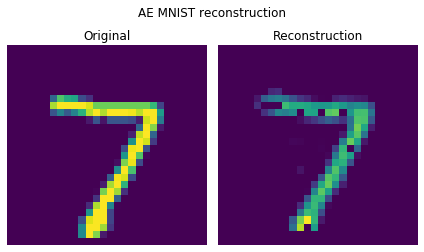

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2)

# original
axs[0].imshow(
    batch_features[0].data.view(28, 28),
    aspect="equal"
)
axs[0].set_title("Original")
axs[0].axis('off')

# reconstruction
axs[1].imshow(
    outputs[0].data.view(28, 28),
    aspect="equal"
)
axs[1].set_title("Reconstruction")
axs[1].axis('off')

plt.suptitle("AE MNIST reconstruction")
plt.tight_layout()
plt.show()